In [35]:
import numpy as np
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs


podatci sintetički MAKE MOONS

In [36]:
X, y = datasets.make_moons(n_samples=200, noise=0.05, random_state=42)
# broj točaka
n = X.shape[0]  

## 1. affinity/similarity matrix


In [37]:
# init. adjacency marticu 
A = np.zeros((n, n)) 

# moram napraviti matricu s euclidian udaljenostima
dists = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n): 
        dist = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        dists[i, j] = dist
        dists[j, i] = dist 
k=10
        
## kk-nn metoda       
for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in neighbors:
        A[i][j] = np.exp(-dists[i][j]**2 / 0.1) 
        A[j][i] = A[i][j]
# pripaziti da su na dijagonali 0
np.fill_diagonal(A, 0)



# RBF metoda
""" for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in range(n):
        # RBF similarity function
        ##A[i,j] = np.exp(-np.sum((X[i] - X[j])**2) / (2 * sigma**2))
        # RBF krenel with euclidian distance
        dist_ij = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        A[i,j] = np.exp(-1.0 * dist_ij ** 2)  """


""" - more controlled decay
    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti
    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava
        - malena sigma: sličnost pada brzo kako se distanca povećava
        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje
          imaju veliku sličnost"""

' - more controlled decay\n    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti\n    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava\n        - malena sigma: sličnost pada brzo kako se distanca povećava\n        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje\n          imaju veliku sličnost'

## 2. degree matrix

In [38]:
# trebamo matricu koja je suma redaka od ajd
D = np.zeros((n, n))  
for i in range(n):
    D[i, i] = np.sum(A[i]) 


3. un-normalized laplacian

In [39]:
L = D - A
""" dijagonalni elementi matrice su stupnjevi čvorova, a ne-dijagonalni elementi 
"""
# https://freedium.cfd/https://medium.com/@roiyeho/spectral-clustering-50aee862d300


# normalized laplacian
""" D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)
L = D_inv_sqrt @ L @ D_inv_sqrt """

' D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)\nL = D_inv_sqrt @ L @ D_inv_sqrt '

4. eigenvalues/ eigenvectors

In [40]:
# preko built in funkcije
eigvals, eigvecs = np.linalg.eig(L)
#print("Eigenvalues:", eigvals)
#print("Eigenvectors:", eigvecs)

# det(L -I*lambda) = 0  karakteristični polinomial čija su rješenja lambda1, lambda2...
# riješiti (L - lambda*I) v = 0 za svaku lambdu/eigenvrijednost

# uzimam drugi najmanji fiedlerov vektor na temelju kojeg dijelim
fiedler_vector = eigvecs[:, 1]

5. visualization

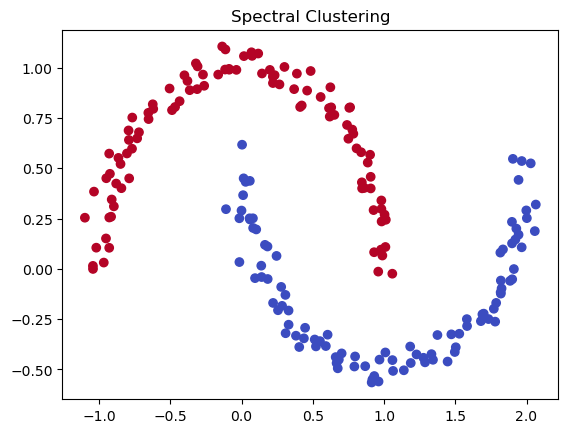

In [41]:
# dijelim podatke u ovisnosti o pozitivnosti/negativnosti
clusters = np.where(fiedler_vector >= 0, 1, 0)

# vizualizacija
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="coolwarm")
plt.title("Spectral Clustering")
plt.show()

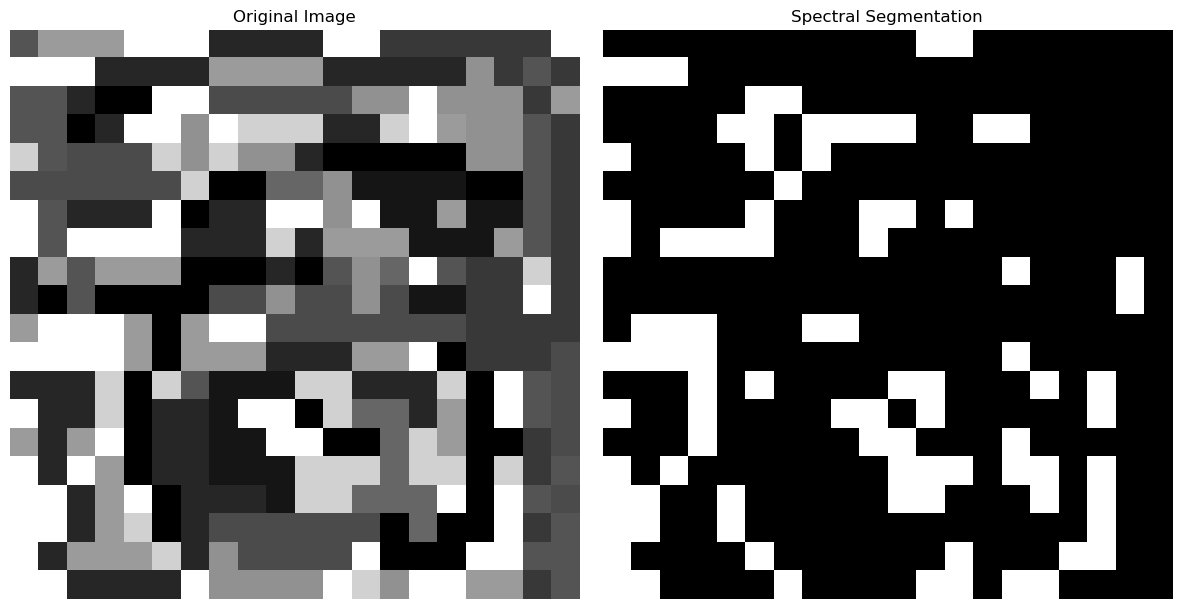

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.preprocessing import normalize

#-----------------------učitavanje slike-----------------------------
img = io.imread('image3.png', as_gray=True)
img = img.astype(np.float64)
rows, cols = img.shape

#------------------pretvaranje pixela u čvorove-----------------------
X = np.array([(i, j) for i in range(rows) for j in range(cols)])
intensities = img.flatten()
n = X.shape[0]

""" 1.KORAK """
#---------------------- iz rada formula za simm.----------------------
sigma_I = 0.1  # intensity scale
sigma_X = 5.0  # spatial scale
r = 10     # spatial cutoff (Euclidean distance in pixel space)

W = np.zeros((n, n))  # simmilarity matrix prema brightness
for i in range(n):
    for j in range(i + 1, n):
        spatial_dist_sq = np.sum((X[i] - X[j]) ** 2)
        if spatial_dist_sq < r ** 2:
            intensity_diff_sq = (intensities[i] - intensities[j]) ** 2
            w_ij = np.exp(-intensity_diff_sq / (sigma_I ** 2)) * \
                   np.exp(-spatial_dist_sq / (sigma_X ** 2))
            W[i, j] = w_ij
            W[j, i] = w_ij 
# W je sparse jer se povezuje samo sa susjedima u radijusu r
            
""" 2.KORAK """
#---------------------- eigenvrijednosti - eigenvektori ----------------
D = np.diag(np.sum(W, axis=1))
#L = D - W -> nenormalizirana matrica
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)
L = D_inv_sqrt @ (D-W) @ D_inv_sqrt 

# koristimo Lanczovou metodu da kretiramo manju matricu T umjesto L za 
# izračunavanje eigen... built-in metodom .eigh
# https://arxiv.org/pdf/2410.11090
def lanczos(A, b, k):
    Q = np.zeros((n, k))
    alphas = np.zeros(k)
    betas = np.zeros(k-1)
    
    # Normalize the initial vector
    q_prev = np.zeros(n)  # q_{-1}
    q_curr = b / np.linalg.norm(b)  # q_0
    beta_prev = 0.0  # beta_{-1}
    
    for i in range(k):
        Q[:, i] = q_curr
        
        # Step 4: y = A @ q_i - beta_{i-1} * q_{i-1}
        if callable(A):
            y = A(q_curr) - beta_prev * q_prev
        else:
            y = A @ q_curr - beta_prev * q_prev
        
        # Step 5: alpha_i = q_i^T y
        alpha_i = q_curr.T @ y
        alphas[i] = alpha_i
        
        # Step 6: z = y - alpha_i * q_i
        z = y - alpha_i * q_curr
        
        # Step 8: beta_i = ||z||_2
        if i < k - 1:
            beta_i = np.linalg.norm(z)
            betas[i] = beta_i
            
            # Step 9: q_{i+1} = z / beta_i
            q_prev = q_curr
            q_curr = z / beta_i
            beta_prev = beta_i
    
    return Q, alphas, betas

def fiedler_vector_lanczos(A, k):
    b = np.random.rand(A.shape[0])
    Q, alphas, betas = lanczos(A, b, k)
    # tridijagonalna matrica
    T = np.diag(alphas) + np.diag(betas, 1) + np.diag(betas, -1)
    
    # TODO: zamijeniti built-in .eigh funkciju
    eigvals, eigvecs = np.linalg.eigh(T)

    u_fiedler = eigvecs[:, 1]
    v_approx = Q @ u_fiedler

    return v_approx



# Fiedler vector (second smallest eigenvalue)


fiedler_vector = fiedler_vector_lanczos(L ,15)



""" 3.KORAK """
#----------------------------- N-cut ----------------------------------
# Currently, the search is done by checking l evenly spaced possible 
# splitting points, and computing the best Ncut among them.
#clusters = np.where(fiedler_vector >= 0, 1, 0) 

def n_cut(A, B):


    # Cut between A and B: sum of weights of edges between A and B
    cut_AB = np.sum(W[A, :][:, B])

    # Association values for A and B: sum of weights of edges connected to nodes in A and B
    assoc_A = np.sum(D[A, :])  # Sum of degrees for nodes in A
    assoc_B = np.sum(D[B, :])  # Sum of degrees for nodes in B

    # Normalized cut calculation
    ncut_value = (cut_AB / assoc_A) + (cut_AB / assoc_B)
    return ncut_value


        
    
l=10
min_l = l
min_n_cut = np.inf
sorted_indices = np.argsort(fiedler_vector)
for i in range(l, len(fiedler_vector) - l, l):  # avoid too small/large clusters
    A = sorted_indices[:i]
    B = sorted_indices[i:]
    current_ncut = n_cut(A, B)
    if current_ncut < min_n_cut:
        min_n_cut = current_ncut
        min_l = i
        
final_A = sorted_indices[:min_l]
final_B = sorted_indices[min_l:]

clusters = np.zeros(n)
clusters[final_B] = 1


""" 4.KORAK """
#-------------------------- Rekurzivno pozivanje ----------------------

#-------------------------- Vizualizacija -----------------------------
segmented_img = clusters.reshape((rows, cols))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Segmented image
axs[1].imshow(segmented_img, cmap='gray')
axs[1].set_title('Spectral Segmentation')
axs[1].axis('off')

plt.tight_layout()
plt.show()

